In [25]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
pd.options.display.max_rows = 4000

In [187]:
gpu_df= pd.DataFrame(columns=['user', 'jobid','V100_32GB','V100_16GB','A100_40GB','CPU', 'RAM','energy','gpu_name','group_name','duration', 'gpu_type','jobname','start_time', 'end_time', 'location'])

In [188]:
gpu_df.columns

Index(['user', 'jobid', 'V100_32GB', 'V100_16GB', 'A100_40GB', 'CPU', 'RAM',
       'energy', 'gpu_name', 'group_name', 'duration', 'gpu_type', 'jobname',
       'start_time', 'end_time', 'location'],
      dtype='object')

In [193]:
for p in Path('../logs/').glob('*.txt'):
    print(p)
    user= str(p).split('_')[3]
    with p.open() as log:
        for l in log.readlines():
            gpu_logs= [s for s in l.split('|')]
            #gpu_logs[14]= str(gpu_logs[14]).replace('\n','')
            gpu_logs.insert(0, user)
            
            #print(len(logs))
            gpu_log_series = pd.Series(gpu_logs, index = gpu_df.columns)
            gpu_df=gpu_df.append(gpu_log_series, ignore_index=True)

../logs/2022_02_08_TVN_jz_logs.txt
../logs/2022_02_03_pierre_colombo_logs.txt
../logs/2022_02_08_lucile_jz_logs.txt
../logs/2022_02_02_stas_jz_logs.txt
../logs/2022_02_02_sylvain_jz_logs.txt
../logs/2022_02_02_victor_jz_logs.txt


In [190]:
gpu_df.head()

,user,jobid,V100_32GB,V100_16GB,A100_40GB,CPU,RAM,energy,gpu_name,group_name,duration,gpu_type,jobname,start_time,end_time,location
0,TVN,1194151,8,0,0,20,300000M,4074,gpu_p2l,genhug01,00:00:29,qos_gpu-t4,gpt2_repro_initial,2021-05-01T22:50:06,2021-05-01T22:50:35,/gpfsdswork/projects/rech/ajs/uhk85as\n
1,TVN,1194169,8,0,0,20,300000M,45368,gpu_p2l,genhug01,00:04:47,qos_gpu-t4,gpt2_repro_initial,2021-05-01T22:59:04,2021-05-01T23:03:51,/gpfsdswork/projects/rech/ajs/uhk85as\n
2,TVN,1296819,0,2,0,8,16G,960533,gpu_p13,genhug01,01:00:11,qos_gpu-dev,bash,2021-05-06T11:59:38,2021-05-06T12:59:49,/gpfsdswork/projects/rech/ajs/uhk85as\n
3,TVN,1300452,0,2,0,8,16G,1328889,gpu_p13,genhug01,01:00:05,qos_gpu-dev,bash,2021-05-06T14:11:02,2021-05-06T15:11:07,/gpfsdswork/projects/rech/ajs/uhk85as\n
4,TVN,1303289,0,0,0,N/A,N/A,N/A,gpu_p13,genhug01,00:00:00,qos_gpu-dev,bash,2021-05-06T16:56:19,2021-05-06T16:56:19,/gpfsdswork/projects/rech/ajs/uhk85as\n


In [194]:
gpu_df.to_csv('jz-logs_09.02.csv')

## Runs on Jean-Zay

#### Info from Stas:
In essence we have:
1. main track - where we train gpt models - 13B, 104B, 200B - I'm your contact here. when we talk about 13B-en training we say tr1, when we refer to 104B experiments it's tr8 (and tr8b)
2. t0 track - @Victor -- trained on TPUs?
3. multiple other supportive trainings in preparation for either (1) or (2) - the rest of the group I listed above

e.g. there were many 1.3B trainings where new features were experimented on.

the 104B track was never meant to be completed - it was a training wheels for the 200B final training (which might not be 200B at the end but less since we don't have enough hardware/time). 
as of today we used 1.8M gpus hours, 1.25M of which were on track 1 and the rest on track 3 (may be some of 2 as well) 

### Idea from Stas:
if you had the command lines, then you just parse on <code>\s\S+.py\s</code> and you will get all categories automatically
(assuming that the scripts were all ending with .py but that's usually the case.

If not it's always starting with python so:
<code>python \s\S+\s</code>

#### Compute resources information:
https://github.com/bigscience-workshop/bigscience/blob/master/jz/compute-resources.md


In [2]:
carbon_df= pd.read_csv('carbon_09.02.csv')
print(carbon_df.shape)

(81320, 40)


In [3]:
carbon_df['carbonEmissions'].sum()/1000

39101.194733753044

In [238]:
gpu_df['jobname'].value_counts()

extract_embeddings                                                                  5241
seq_cache_tasks                                                                     4545
cron-hourly                                                                         4336
tr9c-1B3-hub-sync-logs                                                              3347
modelling-metadata-c4-dataset-toy-add-metadata-full                                 2925
modelling-metadata-c4-dataset-toy-add-website-desc                                  2844
modelling-metadata-c4-dataset-export-to-jsonlines                                   2802
tr4c-1B3-oscar-hub-sync-logs                                                        2777
tr7a-1B3-alibi-hub-sync-logs                                                        2774
modelling-metadata-c4-dataset-toy-add-metadata-full-v3                              2761
tr8-104B-hub-sync-logs                                                              2636
tr8b-104B-hub-sync-lo

In [51]:
carbon_dict={}
for df in carbon_df.groupby('jobname'):
    carbon_dict[df[0]]= df[1]['carbonEmissions'].sum()/1000
print(len(carbon_dict))

2967


In [64]:
n = 100
i = 0

carbon_dict_top = OrderedDict()


for k, v in sorted(carbon_dict.items(), key=lambda item: item[1], reverse=True):
    carbon_dict_top[k] = v
    i += 1
    if i == n:
        break

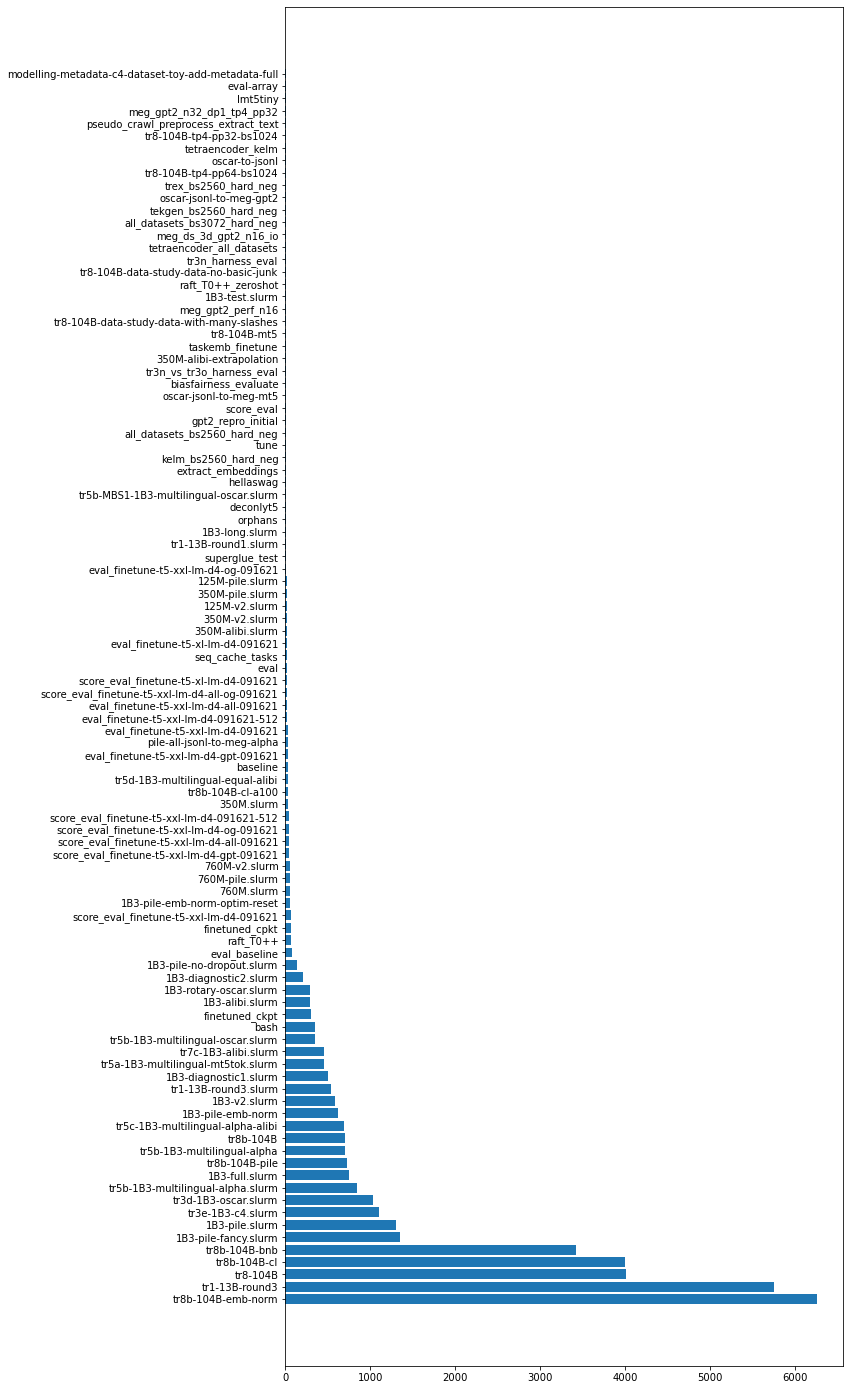

In [66]:
names = list(carbon_dict_top.keys())
values = list(carbon_dict_top.values())
plt.figure(figsize=(10,25))
#plt.xticks(rotation='vertical')

plt.barh(range(len(carbon_dict_top)), values, tick_label=names)

plt.show()

### 13 billion round 3 training

In [209]:
B13_df= carbon_df[carbon_df['jobname'] == 'tr1-13B-round3'].sort_values('carbonEmissions', ascending=False)
B13_df.shape

(67, 40)

In [212]:
B13_df[['user','jobid','jobname','start_time','end_time','runTime','carbonEmissions']].sort_values('carbonEmissions', ascending=False)

,user,jobid,jobname,start_time,end_time,runTime,carbonEmissions
29340,stas,780561_1,tr1-13B-round3,2021-08-24T16:25:12,2021-08-25T12:17:21,19.866667,220859.898800
29341,stas,780561_2,tr1-13B-round3,2021-08-25T12:17:28,2021-08-26T08:09:51,19.866667,220859.898800
30333,stas,848126_2,tr1-13B-round3,2021-09-05T12:00:44,2021-09-06T07:51:59,19.850000,220674.613650
29623,stas,803028_5,tr1-13B-round3,2021-08-30T16:38:14,2021-08-31T12:29:17,19.850000,220674.613650
29628,stas,803028_10,tr1-13B-round3,2021-09-03T19:53:16,2021-09-04T15:43:29,19.833333,220489.328500
29069,stas,768189_1,tr1-13B-round3,2021-08-21T23:10:05,2021-08-22T19:00:30,19.833333,220489.328500
29619,stas,803028_1,tr1-13B-round3,2021-08-27T09:11:23,2021-08-28T05:01:27,19.833333,220489.328500
29621,stas,803028_3,tr1-13B-round3,2021-08-29T00:52:02,2021-08-29T20:42:07,19.833333,220489.328500
29622,stas,803028_4,tr1-13B-round3,2021-08-29T20:42:26,2021-08-30T16:32:30,19.833333,220489.328500
30332,stas,848126_1,tr1-13B-round3,2021-09-04T15:43:35,2021-09-05T11:33:49,19.833333,220489.328500


In [213]:
B13_df['carbonEmissions'].sum()/1000

5758.164899899

### Oscar 1B model

In [214]:
B1_oscar_df= carbon_df[carbon_df['jobname'].str.contains('tr3d-1B3-oscar')].sort_values('carbonEmissions', ascending=False)
B1_oscar_df.shape

(136, 40)

In [215]:
B1_oscar_df['carbonEmissions'].sum()/1000

1031.884622166059

### C4 1B model

In [216]:
B1_c4_df= carbon_df[carbon_df['jobname'].str.contains('tr3e-1B3-c4')].sort_values('carbonEmissions', ascending=False)
B1_c4_df.shape

(196, 40)

In [217]:
B1_c4_df['carbonEmissions'].sum()/1000

1103.5875236845773

#### TODO: (No idea what's going on with the tr4 runs)

### 1B Multilingual Alpha

In [88]:
B1_multilingual_df= carbon_df[carbon_df['jobname'] == 'tr5b-1B3-multilingual-alpha'].sort_values('carbonEmissions', ascending=False)
B1_multilingual_df.shape

(42, 39)

In [89]:
B1_multilingual_df['carbonEmissions'].sum()/1000

705.843778925

#### TODO: What's 'alibi'? 

### 1B Multilingual Tokenizer ? 

In [90]:
B1_multilingual_tok_df = carbon_df[carbon_df['jobname'].str.contains('tok')].sort_values('carbonEmissions', ascending=False)
B1_multilingual_tok_df.shape

(75, 39)

In [91]:
B1_multilingual_tok_df['carbonEmissions'].sum()/1000

226.97692573931423

### 1B3-prefix-lm

In [96]:
B1_prefix_df = carbon_df[carbon_df['jobname'].str.contains('tr6')].sort_values('carbonEmissions', ascending=False)
B1_prefix_df.shape

(3913, 39)

In [93]:
B1_prefix_df['carbonEmissions'].sum()/1000

0.00527927015762807

#### TODO: why so low?

### 1B3-alibi

In [99]:
B1_alibi_df = carbon_df[carbon_df['jobname'].str.contains('tr7')].sort_values('carbonEmissions', ascending=False)
B1_alibi_df.shape

(3265, 39)

In [100]:
B1_alibi_df['carbonEmissions'].sum()/1000

453.8856489221267

### tr8-104B

In [104]:
B104_df = carbon_df[carbon_df['jobname'].str.contains('tr8')].sort_values('carbonEmissions', ascending=False)
B104_df.shape

(6805, 39)

In [105]:
B104_df['carbonEmissions'].sum()/1000

18823.832147622063

### T9 (log syncing?) 

In [114]:
log_df= carbon_df[carbon_df['jobname'].str.contains('tr9')].sort_values('jobname', ascending=False)
log_df.shape

(3358, 39)

In [115]:
log_df['carbonEmissions'].sum()/1000

0.002833551298996775

## T0 Runs

#### Info from Victor:

preprocessing, on a fait ca sur JZ -> c’est les trucs identifiés comme “seqio” dans mes logs jz

“eval” et “score_eval”, ce sont les evaluations des checkpoints t0

logs are here: https://console.cloud.google.com/storage/browser/bigscience/experiment_d;tab=objects?pli=1&prefix=&forceOnObjectsSortingFiltering=false&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))

### Info from the T0 paper

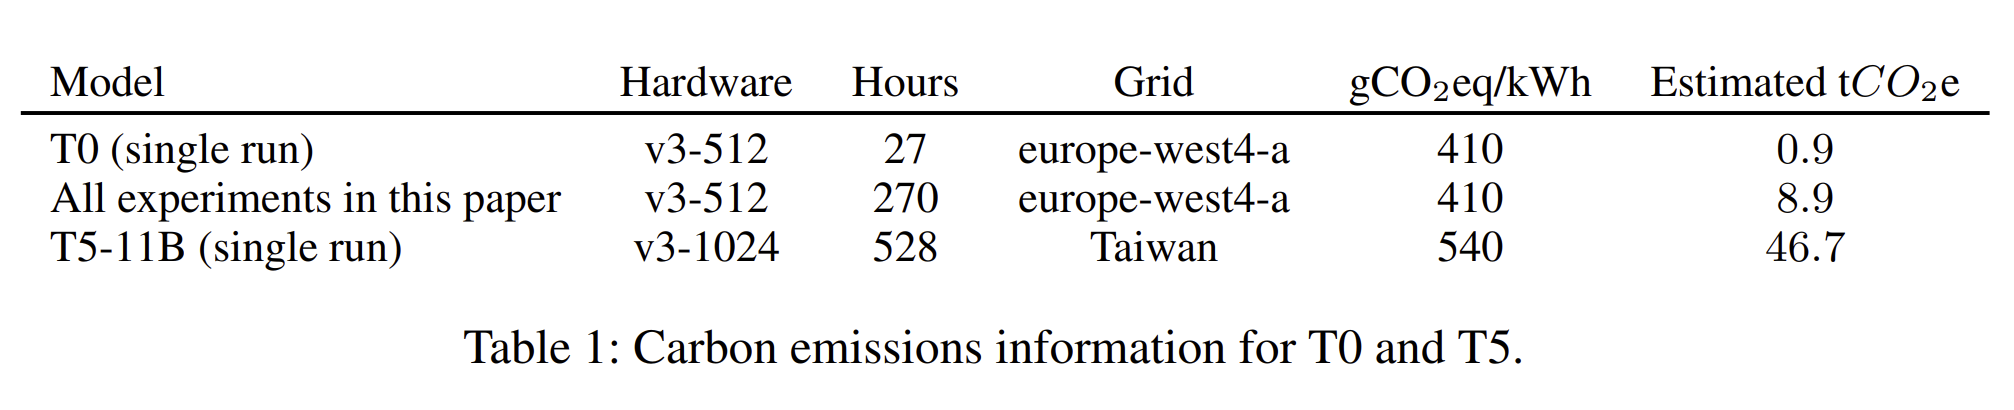

### Preprocessing runs

In [118]:
t0_preprocess_df = carbon_df[carbon_df['jobname'].str.contains('seqio')].sort_values('jobname', ascending=False)
t0_preprocess_df.shape

(1949, 39)

In [119]:
t0_preprocess_df['carbonEmissions'].sum()/1000

0.7202408479500001

### Evaluation runs

In [138]:
t0_eval_df = carbon_df[carbon_df['jobname'] == 'eval'].sort_values('jobname', ascending=False)
t0_eval_df.shape

(267, 39)

In [143]:
t0_eval_df.head()

,Unnamed: 0,coreType,CPUmodel,n_CPUcores,CPUpower,GPUmodel,n_GPUs,GPUpower,memory,runTime_hours,...,nkm_drivingEU,nkm_train,flying_context,flying_text,text_CE,permalink,jobid,jobname,start_time,end_time
69465,69465,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.023566,0.100588,0.000082,Paris-London,4.12 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1160671_0,eval,2021-09-24T01:04:09,2021-09-24T01:08:15
69648,69648,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.017675,0.075441,0.000062,Paris-London,3.09 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1160671_183,eval,2021-09-24T07:59:24,2021-09-24T08:02:26
69634,69634,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.011783,0.050294,0.000041,Paris-London,2.06 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1160671_169,eval,2021-09-24T07:52:29,2021-09-24T07:55:06
69635,69635,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.011783,0.050294,0.000041,Paris-London,2.06 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1160671_170,eval,2021-09-24T07:53:14,2021-09-24T07:56:00
69636,69636,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.011783,0.050294,0.000041,Paris-London,2.06 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1160671_171,eval,2021-09-24T07:53:49,2021-09-24T07:56:27


In [144]:
t0_eval_df['carbonEmissions'].sum()/1000

16.165456262025003

In [141]:
t0_score_eval_df = carbon_df[carbon_df['jobname'] == 'score_eval'].sort_values('jobname', ascending=False)
t0_score_eval_df.shape

(128, 39)

In [145]:
t0_score_eval_df.head()

,Unnamed: 0,coreType,CPUmodel,n_CPUcores,CPUpower,GPUmodel,n_GPUs,GPUpower,memory,runTime_hours,...,nkm_drivingEU,nkm_train,flying_context,flying_text,text_CE,permalink,jobid,jobname,start_time,end_time
69731,69731,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.141398,0.603527,0.000495,Paris-London,24.74 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1163157_0,score_eval,2021-09-24T11:37:26,2021-09-24T12:02:14
69732,69732,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.135506,0.578380,0.000474,Paris-London,23.71 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1163157_1,score_eval,2021-09-24T11:42:36,2021-09-24T12:05:55
69825,69825,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.088374,0.377205,0.000309,Paris-London,15.47 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1163157_94,score_eval,2021-09-24T15:08:39,2021-09-24T15:24:18
69824,69824,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,0,...,0.306362,1.307643,0.001072,Paris-London,53.61 g CO2e,https://green-algorithms.org//?runTime_hour=0&...,1163157_93,score_eval,2021-09-24T15:08:39,2021-09-24T16:00:54
69823,69823,Both,Xeon Gold 6248,12.0,7.5,V100_32GB,4,300,90.0,2,...,0.813038,3.470283,0.002846,Paris-London,142.28 g CO2e,https://green-algorithms.org//?runTime_hour=2&...,1163157_92,score_eval,2021-09-24T15:07:05,2021-09-24T17:25:17


In [146]:
t0_score_eval_df['carbonEmissions'].sum()/1000

7.088303578125